In [5]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [6]:
pickle_file = '../btc-autotrader/lib/data/log/2019-04-15T12:23:35.195300.pickle'

In [7]:
df = pd.read_pickle(pickle_file)

In [8]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,target_price,size
0,2019-04-15 12:23:40.895420,33739.0,0,0.005006,577543.0,0,None,0,None,577627.0,577800.0,577713.0,0,0,0,0
0,2019-04-15 12:23:45.917864,33739.0,0,0.005006,577543.0,0,1.09908,0,None,577545.0,577800.0,577672.0,0,0,0,0
0,2019-04-15 12:23:50.941246,33739.0,0,0.005006,577543.0,4,1.09908,0,0,577679.0,577800.0,577739.0,0,0,0,0
0,2019-04-15 12:23:55.963239,27961.0,0,0.014993,577543.0,2,1.09908,0,0,577601.0,577800.0,577700.0,577800,0,0,0
0,2019-04-15 12:24:00.984146,27961.0,0,0.014993,577601.0,3,1.09908,0,0,577601.0,577784.0,577692.0,577800,0,0,0


In [9]:
df['spread'] = df.ask_low - df.bid_high

In [10]:
df['spread_pct_change'] = df.spread.pct_change()

In [11]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [12]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [13]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

In [14]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [15]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,bought_price,sold_price,target_price,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-15 12:26:06.513644,27961.0,0,0.00498,577600.0,3,-0.248841,0,-0.0282095,577600.0,...,577800,0,0,0,67.0,0.000000,-1.0,-0.313617,0.0,-0.0
0,2019-04-15 12:26:11.533973,27961.0,0,0.00498,577600.0,3,-0.316428,0,-0.0134682,577600.0,...,577800,0,0,0,67.0,0.000000,-1.0,-0.313617,0.0,-0.0
0,2019-04-15 12:26:16.560132,27961.0,0,0.00498,577600.0,3,-0.375098,0,-0.011695,577600.0,...,577800,0,0,0,67.0,0.000000,-1.0,-0.313617,0.0,-0.0
0,2019-04-15 12:26:21.584661,27961.0,0,0.00498,577600.0,3,-0.375098,0,0,577600.0,...,577800,0,0,0,66.0,-0.014925,-1.0,-0.313617,0.0,-0.0
0,2019-04-15 12:26:26.614095,27961.0,0,0.00498,577600.0,3,-0.735787,0,-0.0717613,577600.0,...,577800,0,0,0,66.0,0.000000,-1.0,-0.313617,0.0,-0.0


In [16]:
np.exp(df[['returns', 'strategy']].sum())

returns     1.000099
strategy    1.000099
dtype: float64

/Users/sishida/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


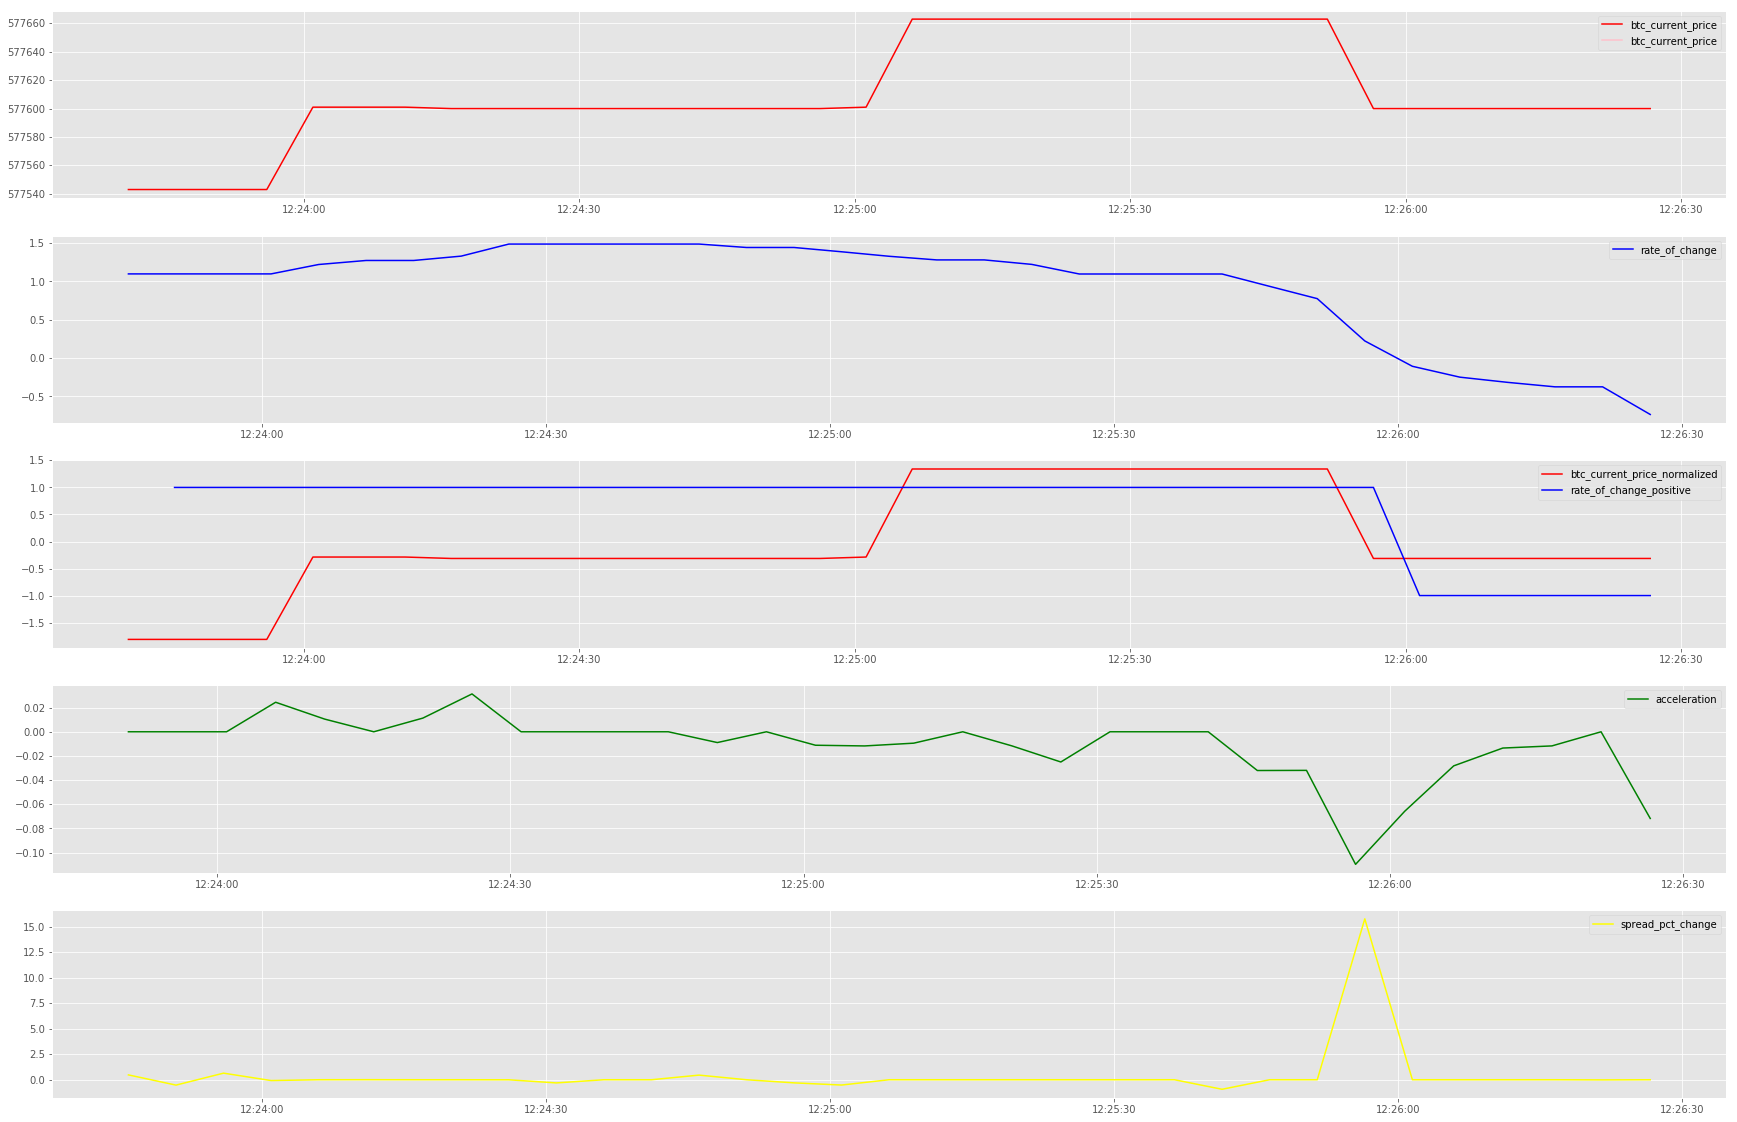

In [17]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

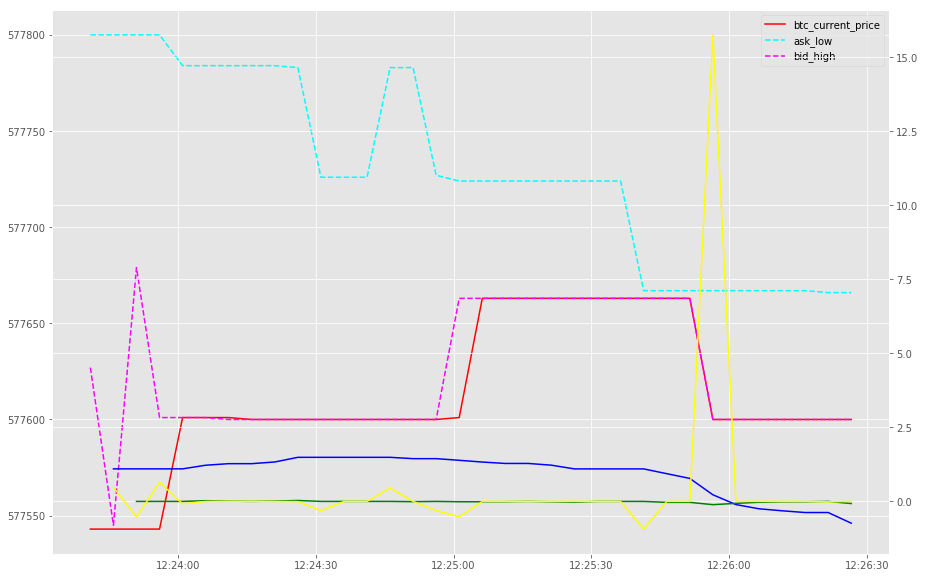

In [18]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

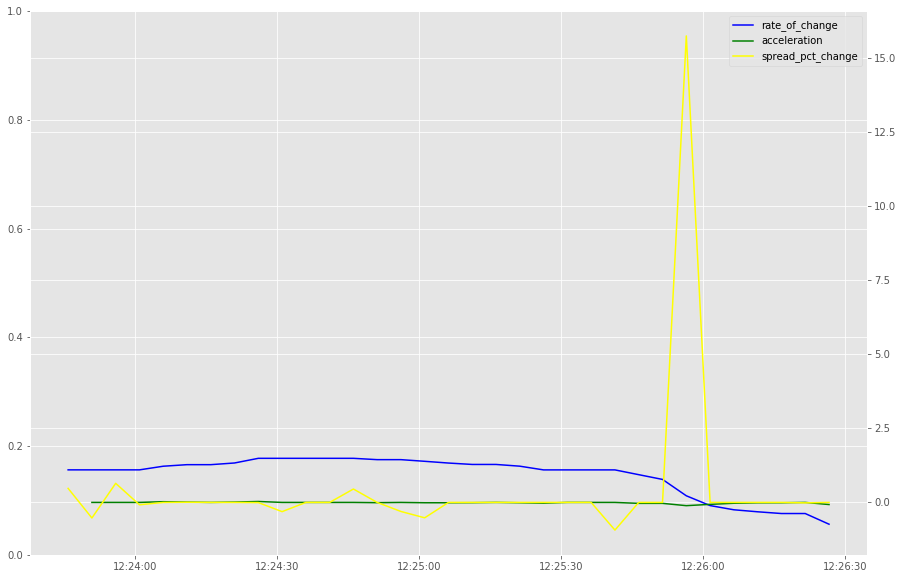

In [19]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

In [20]:
df.total_value.iloc[-1] - df.total_value.iloc[0]

0

No handles with labels found to put in legend.


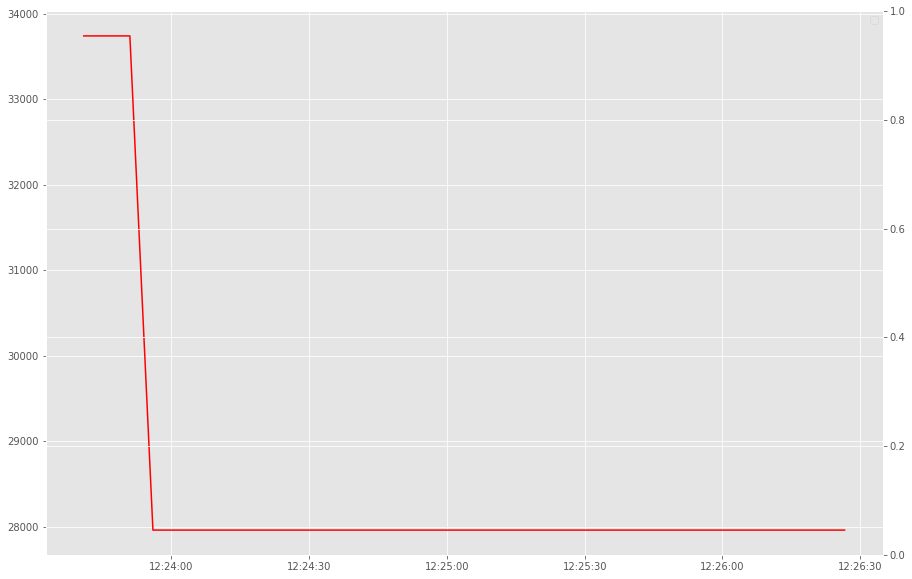

In [21]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.cash, color='r')
#ax2.plot(df.datetime, df.rate_of_change, color='b')
#ax2.plot(df.datetime, df.acceleration, color='g')
ax2.legend()
plt.show()